In [58]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
echo_genres = pd.read_csv('//Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

In [ ]:
echo_genres.genre_top.value_counts()

# Multiclass classification : 8 genres

In [ ]:
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']
# generating dataset for multiclass classification task
echo_gen = echo_genres[echo_genres['genre_top'].isin(genres_subset)]
echo_gen.head()

In [ ]:
echo_gen.shape

In [ ]:
echo_gen.genre_top.value_counts()

In [ ]:
# encoding labels
le = preprocessing.LabelEncoder()
echo_gen['genre_top'] = le.fit_transform(echo_gen['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
echo_gen.genre_top.value_counts()

In [ ]:
# detach target col
labels = echo_gen[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [ ]:
echo_gen.drop('genre_top', axis=1, inplace=True)

In [ ]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_gen)

# 1. PCA on scaled data
### 1.1 scree-plot

In [ ]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### 1.2 cumulative explained variance plot

In [ ]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

### 1.3 plot PCA in 2D

In [ ]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

Rock, Classic and Hip-Hop are well separated from the others.
Jazz instead, is very close to classical (probably due to instrumentality of the two genres), in fact
is located on the leftmost side of the graph.

# 1.4 plot PCA in 3D

In [ ]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()

# 2. Model selection

In [ ]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=10)

In [ ]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

## Model Selection

# 2.1 Decision Tree -  Unbalanced - without PCA
### 2.1.1 10 fold cross validation - grid search

In [34]:
param_grid = {
               "max_depth": [2,3,4,5,6,7,8,9,10, None],
               "min_samples_leaf": [25,35,45,55,75,100,150,250,300,None],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.624 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.624 (std: 0.016)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 3
Mean validation score: 0.623 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 45}

Model with rank: 4
Mean validation score: 0.622 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.621 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 45}

Model with rank: 5
Mean validation score: 0.621 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 45}

Model with rank: 7
Mean validation score: 0.621 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth

### 2.1.2 5 fold cross validation - grid search

In [ ]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)
random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

### 2.1.3 Retrain on full development set and prediction

In [45]:
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=8, min_samples_leaf= 45)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

'''
# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()'''

Accuracy 0.6139124033860875
F1-score [0.59649123 0.576      0.40973631 0.53877551 0.         0.75799087
 0.04580153 0.71767406]
              precision    recall  f1-score   support

           0       0.57      0.63      0.60        81
           1       0.59      0.57      0.58       635
           2       0.48      0.36      0.41       283
           3       0.59      0.50      0.54       266
           4       0.00      0.00      0.00        66
           5       0.78      0.73      0.76       113
           6       0.15      0.03      0.05       111
           7       0.65      0.81      0.72      1162

    accuracy                           0.61      2717
   macro avg       0.48      0.45      0.46      2717
weighted avg       0.58      0.61      0.59      2717



' \n# y_score0 --> scores of decision tree without PCA\n# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA\ny_score0 = dtc.predict_proba(X_test)\nfpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])\n\n# roc_auc0 --> ROC/AUC of decision tree without PCA\nroc_auc0 = auc(fpr0, tpr0)\n\nplt.plot(fpr0, tpr0, color=\'red\', lw=3, label=\'$AUC_{without PCA}$ = %.3f\' % roc_auc0)\n\nplt.plot([0, 1], [0, 1], color=\'black\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\', fontsize=16)\nplt.ylabel(\'True Positive Rate\', fontsize=16)\nplt.title(\'ROC curve - without PCA\', fontsize=16)\nplt.legend(loc="lower right", fontsize=14, frameon=False)\nplt.tick_params(axis=\'both\', which=\'major\', labelsize=16)\nplt.show()'

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 51   0  18   0   0   8   0   4]
 [  3 360  12  35   0   2   3 220]
 [ 12  22 101   9   0   5   3 131]
 [  0  79   2 132   0   1   0  52]
 [  6   4  10   6   0   0   0  40]
 [ 10   1   9   3   0  83   1   6]
 [  2  23  14   7   0   1   3  61]
 [  6 126  44  32   0   6  10 938]]


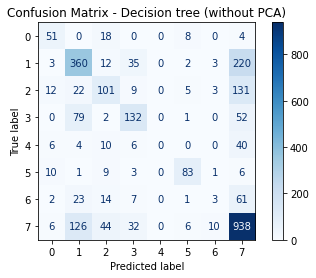

In [49]:
# confusion matrix - Internal Test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

# 2.2 Decision Tree -  Unbalanced - with PCA
### 2.2.1 10 fold cross validation - grid search

In [50]:
# model
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.586 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.586 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 35}

Model with rank: 3
Mean validation score: 0.585 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 35}

Model with rank: 4
Mean validation score: 0.584 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 35}

Model with rank: 5
Mean validation score: 0.584 (std: 0.019)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 25}

Model with rank: 6
Mean validation score: 0.584 (std: 0.019)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 7
Mean validation score: 0.583 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_

### 2.2.2 5 fold cross validation - grid search

In [ ]:
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

### 2.2.3 Retrain on full development set and prediction

In [51]:
dtc_pca = DecisionTreeClassifier(criterion= 'entropy',max_depth=10, min_samples_leaf= 35)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

'''
# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(Xpca_test)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show() '''

Accuracy 0.5852042694147958
F1-score [0.44848485 0.55565294 0.35081374 0.55335968 0.         0.51879699
 0.         0.7083016 ]
              precision    recall  f1-score   support

           0       0.44      0.46      0.45        81
           1       0.63      0.50      0.56       635
           2       0.36      0.34      0.35       283
           3       0.58      0.53      0.55       266
           4       0.00      0.00      0.00        66
           5       0.45      0.61      0.52       113
           6       0.00      0.00      0.00       111
           7       0.64      0.80      0.71      1162

    accuracy                           0.59      2717
   macro avg       0.39      0.40      0.39      2717
weighted avg       0.54      0.59      0.56      2717



'\n# y_score1 --> scores of decision tree with PCA\n# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA\ny_score1 = dtc_pca.predict_proba(Xpca_test)\nfpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])\n\n# roc_auc1 --> ROC/AUC of decision tree with PCA\nroc_auc1 = auc(fpr1, tpr1)\n\nplt.plot(fpr1, tpr1, color=\'blue\', lw=3, label=\'$AUC_{with PCA}$ = %.3f\' % roc_auc1)\n\nplt.plot([0, 1], [0, 1], color=\'black\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\', fontsize=16)\nplt.ylabel(\'True Positive Rate\', fontsize=16)\nplt.title(\'ROC curve - with PCA\', fontsize=16)\nplt.legend(loc="lower right", fontsize=14, frameon=False)\nplt.tick_params(axis=\'both\', which=\'major\', labelsize=16)\nplt.show() '

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 37   0  25   0   0  15   0   4]
 [  5 317  26  34   0  10   0 243]
 [ 19  10  97  12   0  21   0 124]
 [  0  63   3 140   0   9   0  51]
 [  6   3  22   3   0   3   0  29]
 [  6   2  25   2   0  69   0   9]
 [  2  10  12  11   0   2   0  74]
 [  9 101  60  38   0  24   0 930]]


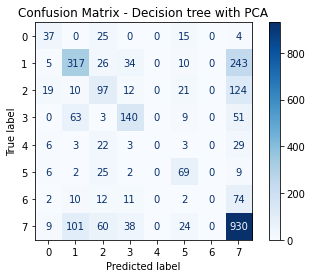

In [52]:
# confusion matrix Decision tree with PCA
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 2.3 Comparing ROC Decision tree (unbalanced) with and without PCA

In [ ]:
'''
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()'''

# 3.1 KNN binary class - Unbalanced (without PCA)

### 3.1.1 10 fold cross validation - grid search

In [60]:
# range of k to try - find a good range of k
k_range = range(1, 40)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_develop, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 39/39 [00:26<00:00,  1.47it/s]


[0.5455980484498733, 0.5121468546453969, 0.5799948669646817, 0.5968778188088368, 0.6014509545950633, 0.6113856205241676, 0.6175430203178494, 0.6247982916461096, 0.6266927803609074, 0.6292201773139773, 0.6307957201449211, 0.6304807610846154, 0.6311091841463962, 0.6360012658164765, 0.6337928147472603, 0.6348971648701043, 0.6331621490972337, 0.6317418432081969, 0.6314276316773065, 0.6333218712156323, 0.6323754989758846, 0.6339522876891872, 0.6348989091054066, 0.634901650046596, 0.6334798490987288, 0.6345841992215726, 0.633797299923752, 0.6344289622796657, 0.6372683281753804, 0.6358482714628153, 0.6353735902841111, 0.6339550286303766, 0.6339540319244895, 0.6330081580376854, 0.6328489342722303, 0.6296948584926816, 0.6293791519029608, 0.6298520888463628, 0.6304830036728613]
maximum score: 0.6372683281753804 for k = 29


Text(0, 0.5, 'Cross-validated accuracy')

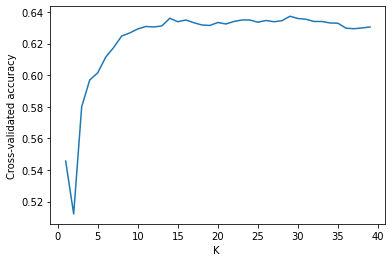

In [61]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - without PCA)

In [ ]:
X_test.shape, y_test.shape

In [62]:
knn_classifier =  KNeighborsClassifier(n_neighbors = 29)

# retrain knn on the whole development set
knn_classifier.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn_classifier.predict(X_test)
# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Hip-Hop\n1: Rock')

'''
# plot ROC curve -KNN
y_score_knn0 = knn_classifier.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()'''

              precision    recall  f1-score   support

           0       0.53      0.69      0.60        81
           1       0.66      0.56      0.61       635
           2       0.42      0.41      0.41       283
           3       0.63      0.52      0.57       266
           4       0.00      0.00      0.00        66
           5       0.80      0.65      0.72       113
           6       0.33      0.01      0.02       111
           7       0.66      0.83      0.74      1162

    accuracy                           0.63      2717
   macro avg       0.50      0.46      0.46      2717
weighted avg       0.60      0.63      0.60      2717

legend:
0: Hip-Hop
1: Rock


'\n# plot ROC curve -KNN\ny_score_knn0 = knn_classifier.predict_proba(X_test)\nfpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])\nroc_auc_knn0 = auc(fpr_knn0, tpr_knn0)\n\nplt.plot(fpr_knn0, tpr_knn0, color=\'red\', lw=3, label=\'$AUC_{KNN}$ = %.3f\' % roc_auc_knn0)\n\nplt.plot([0, 1], [0, 1], color=\'black\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\', fontsize=16)\nplt.ylabel(\'True Positive Rate\', fontsize=16)\nplt.title(\'ROC curve - without PCA\', fontsize=16)\nplt.legend(loc="lower right", fontsize=14, frameon=False)\nplt.tick_params(axis=\'both\', which=\'major\', labelsize=16)\nplt.show()'

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 56   0  21   0   0   1   0   3]
 [  7 356  27  31   0   5   1 208]
 [ 15  13 116  10   0   2   0 127]
 [  0  61   2 139   0   2   0  62]
 [  8   2  18   3   0   3   0  32]
 [ 10   3  15   2   0  74   0   9]
 [  0  17  21   6   0   0   1  66]
 [  9  89  58  29   0   6   1 970]]


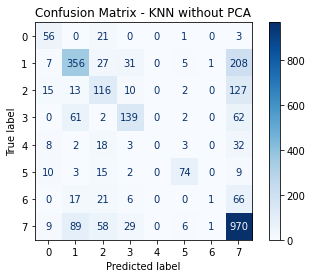

In [63]:
# confusion matrix KNN - Internal test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_knn = plot_confusion_matrix(knn_classifier,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

# 3.2 KNN binary class - Unbalanced (with PCA)
### 3.2.1 10 fold cross validation - grid search

In [64]:
# range of k to try - find a good range of k
k_range = range(1, 40)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn_pca, Xpca_develop, y_develop_pca, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 39/39 [00:21<00:00,  1.81it/s]


[0.5260339577695716, 0.48863655618181906, 0.5668959090206867, 0.5815671705014924, 0.5986098444640464, 0.6022373555399405, 0.606338551088652, 0.6113866172300547, 0.614229471596374, 0.6180162064377233, 0.6162809414883809, 0.6177012473774176, 0.6233827201100364, 0.6274831681293326, 0.6224343544585147, 0.6230657676379565, 0.6238536636416643, 0.6222773732813053, 0.6199114426819363, 0.6230675118732589, 0.6203848779782818, 0.6191227991488132, 0.6192812753848531, 0.6203853763312254, 0.621492218218787, 0.6238581488181559, 0.6225968175181027, 0.6225963191651592, 0.6232272339916577, 0.621648451866581, 0.6216479535136374, 0.623225738932827, 0.6232252405798835, 0.6229095339901626, 0.6200696697415043, 0.6218064297496774, 0.6216474551606939, 0.6208585624510992, 0.6211742690408202]
maximum score: 0.6274831681293326 for k = 14


Text(0, 0.5, 'Cross-validated accuracy')

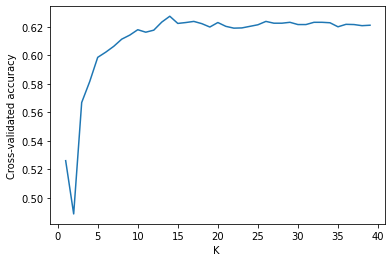

In [65]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - with PCA)

In [67]:
knn_classifier_pca =  KNeighborsClassifier(n_neighbors = 14)
# retrain knn on the whole development set
knn_classifier_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_classifier_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: Hip-Hop\n1: Rock')
'''
# plot ROC curve -KNN
y_score_knn1 = knn_classifier_pca.predict_proba(Xpca_test)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()'''

              precision    recall  f1-score   support

           0       0.52      0.67      0.59        81
           1       0.63      0.54      0.58       635
           2       0.42      0.38      0.40       283
           3       0.62      0.55      0.59       266
           4       0.25      0.02      0.03        66
           5       0.77      0.70      0.73       113
           6       0.00      0.00      0.00       111
           7       0.65      0.82      0.72      1162

    accuracy                           0.62      2717
   macro avg       0.48      0.46      0.45      2717
weighted avg       0.58      0.62      0.59      2717

legend:
0: Hip-Hop
1: Rock


'\n# plot ROC curve -KNN\ny_score_knn1 = knn_classifier_pca.predict_proba(Xpca_test)\nfpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])\nroc_auc_knn1 = auc(fpr_knn1, tpr_knn1)\n\nplt.plot(fpr_knn1, tpr_knn1, color=\'blue\', lw=3, label=\'$AUC_{knnPCA}$ = %.3f\' % roc_auc_knn1)\n\nplt.plot([0, 1], [0, 1], color=\'black\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\', fontsize=16)\nplt.ylabel(\'True Positive Rate\', fontsize=16)\nplt.title(\'ROC curve\', fontsize=16)\nplt.legend(loc="lower right", fontsize=14, frameon=False)\nplt.tick_params(axis=\'both\', which=\'major\', labelsize=16)\nplt.show()'

# Compare KNN ROC with and without PCA

In [ ]:
'''
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
'''

# Compare Decision tree and KNN (best scores)

In [ ]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()